In [51]:
import numpy as np
import os
import pandas as pd
import random
from collections import defaultdict
import gym
import gym_minigrid
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
class QLearning:
    def __init__(self, actions, agent_indicator=10, epsilon_start=0.99, epsilon_end=0.3, epsilon_decay=0.999):
        self.actions = actions
        self.agent_indicator = agent_indicator
        self.alpha = 0.01
        self.gamma = 0.9
        self.epsilon = epsilon_start  # 초기 epsilon 값
        self.epsilon_end = epsilon_end  # 최소 epsilon 값
        self.epsilon_decay = epsilon_decay  # epsilon 감소율
        self.q_values = defaultdict(lambda: [0.0] * actions)
        
    def _convert_state(self, s):
        return np.where(s == self.agent_indicator)[0][0]
        
    def update(self, state, action, reward, next_state, next_action):
        state = self._convert_state(state)
        next_state = self._convert_state(next_state)
        
        q_value = self.q_values[state][action]
        next_q_value = max(self.q_values[next_state])
        td_error = reward + self.gamma * next_q_value - q_value
        self.q_values[state][action] = q_value + self.alpha * td_error
    
    def act(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.actions)
        else:
            state = self._convert_state(state)
            q_values = self.q_values[state]
            action = np.argmax(q_values)
        return action

    def decay_epsilon(self):
        # epsilon이 최소값까지 감소하도록 업데이트
        if self.epsilon > self.epsilon_end:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_end


In [53]:
from utils import gen_wrapped_env, show_video

In [54]:
env = gen_wrapped_env('MiniGrid-LavaGapS5-v0')

obs = env.reset()

agent_position = obs[0]

agent = QLearning(3, agent_position)

## For Q-Learning
+ Q-learning update

In [55]:
rewards = []
for ep in range(50000):
    done = False
    obs = env.reset()
    action = agent.act(obs)
    
    ep_rewards = 0
    while not done:
        next_obs, reward, done, info = env.step(action)

        next_action = agent.act(next_obs)

        agent.update(obs, action, reward, next_obs, next_action)
        
        ep_rewards += reward
        obs = next_obs
        action = next_action
    rewards.append(ep_rewards)
    
    # epsilon 감소
    agent.decay_epsilon()
    
    if (ep+1) % 20 == 0:
        print("episode: {}, rewards: {}, epsilon: {:.4f}".format(ep+1, ep_rewards, agent.epsilon))
env.close()

episode: 20, rewards: 0, epsilon: 0.9704
episode: 40, rewards: 0, epsilon: 0.9512
episode: 60, rewards: 0, epsilon: 0.9323
episode: 80, rewards: 0, epsilon: 0.9138
episode: 100, rewards: 0.5680000000000001, epsilon: 0.8957
episode: 120, rewards: 0, epsilon: 0.8780
episode: 140, rewards: 0, epsilon: 0.8606
episode: 160, rewards: 0, epsilon: 0.8436
episode: 180, rewards: 0, epsilon: 0.8268
episode: 200, rewards: 0, epsilon: 0.8105
episode: 220, rewards: 0, epsilon: 0.7944
episode: 240, rewards: 0, epsilon: 0.7787
episode: 260, rewards: 0, epsilon: 0.7632
episode: 280, rewards: 0.748, epsilon: 0.7481
episode: 300, rewards: 0, epsilon: 0.7333
episode: 320, rewards: 0, epsilon: 0.7188
episode: 340, rewards: 0, epsilon: 0.7045
episode: 360, rewards: 0, epsilon: 0.6906
episode: 380, rewards: 0, epsilon: 0.6769
episode: 400, rewards: 0, epsilon: 0.6635
episode: 420, rewards: 0, epsilon: 0.6503
episode: 440, rewards: 0, epsilon: 0.6375
episode: 460, rewards: 0.15400000000000003, epsilon: 0.6248

In [56]:
{s:np.round(q, 5).tolist() for s, q in agent.q_values.items()}

{0: [0.10446, 0.10443, 0.10829],
 3: [0.13163, 0.12973, 0.16396],
 6: [0.16138, 0.16199, 0.17668],
 15: [0.32939, 0.36169, 0.59919],
 9: [0.13276, 0.13272, 0.15225],
 18: [0.14691, 0.14655, 0.17796],
 21: [0.54257, 0.54245, 0.61141],
 24: [0.0, 0.0, 0.0],
 12: [0.03423, 0.03101, 0.41525]}

In [57]:
show_video()

In [58]:
os.makedirs('./logs', exist_ok=True)
pd.Series(rewards).to_csv('./logs/rewards_qlearning.csv')

In [59]:
sarsa_logs = pd.read_csv('./logs/rewards_sarsa.csv', index_col=False).iloc[:, 1]
q_logs = pd.read_csv('./logs/rewards_qlearning.csv', index_col=False).iloc[:, 1]

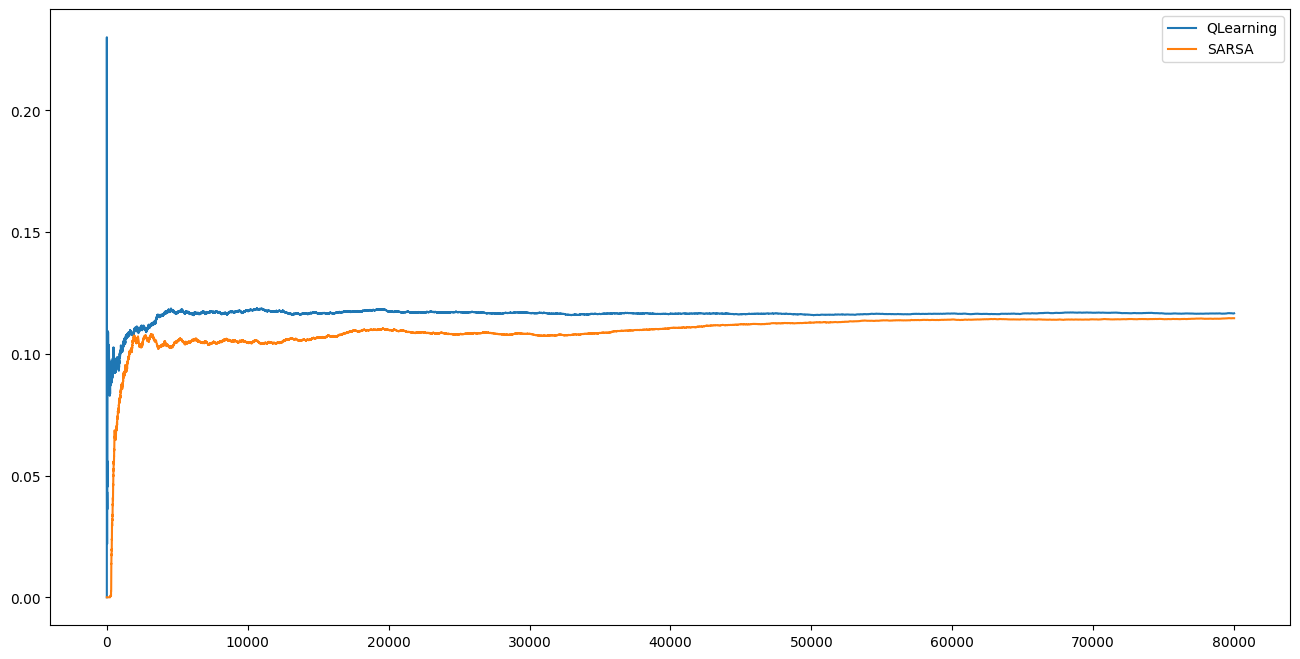

In [60]:
plt.figure(figsize=(16, 8))
plt.plot(q_logs.cumsum() / (pd.Series(np.arange(q_logs.shape[0]))+1), label="QLearning")
plt.plot(sarsa_logs.cumsum() / (pd.Series(np.arange(sarsa_logs.shape[0]))+1), label="SARSA")
plt.legend()